# Import libraries

In [181]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

import shap

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.inspection import PartialDependenceDisplay

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import make_scorer

from sklearn.metrics import confusion_matrix

from scipy.stats import t

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from itertools import combinations

from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
warnings.filterwarnings("ignore")

np.seterr(all='ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/04a_modeling_lr'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class']

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
sns.set_theme()

## Dictionaty for features mapping to type

In [12]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

## Dictionary for mapping *class* to *size group*

In [97]:
class_fraction_group_dict = {
    0: '$0< d \leq 2$',
    1: '$2 < d \leq 5$',
    2: '$d > 5$'
}

# Modeling

In [13]:
initial_features_df = features_df.copy()

print(initial_features_df.shape)
initial_features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Target rate analysis

Mapping hue ~ group:
* Class 0 — $0< d \leq 2$
* Class 1 — $2 < d \leq 5$
* Class 2 — $d > 5$

In [14]:
target_rate_df = pd.DataFrame(samples_description['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')

target_rate_df.T

Fraction_grouped_hue,$0< d \leq 2$,$2 < d \leq 5$,$d > 5$
count,23,29,23


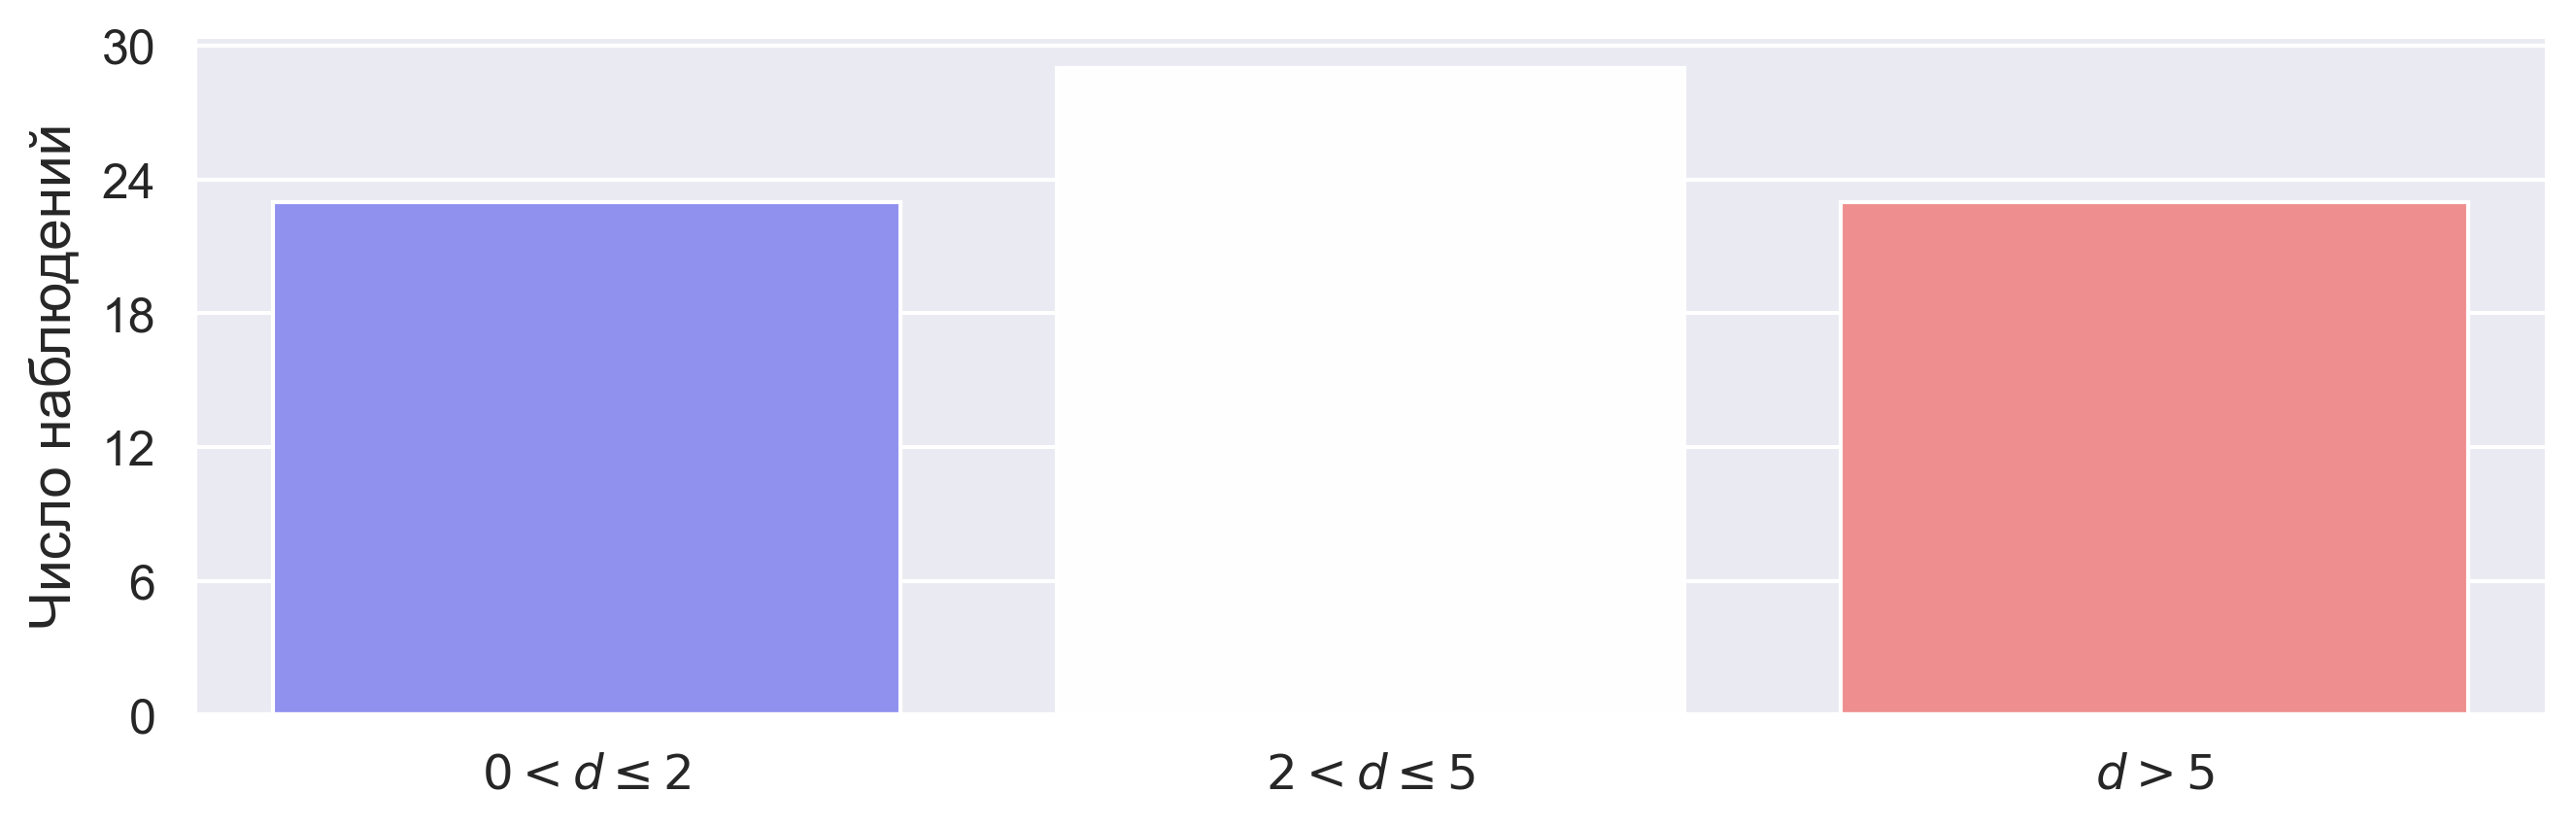

In [15]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

sns.barplot(
    data=target_rate_df,
    x='Fraction_grouped_hue',
    y='count',
    palette='bwr',
    ax=ax
)

ax.set_xlabel('', fontsize=14, labelpad=5)
ax.set_ylabel('Число наблюдений', fontsize=14, labelpad=5)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()

plt.savefig(f'{path_to_save}/target_rate_barplot.png', dpi=600)

plt.show()

## *One-factor* analysis

### Calculation process

In [16]:
def of_analysis(feature, features_df, target, n_splits=5):
    X_raw = features_df[[feature]].values
    y = target.values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    mean_val = scaler.mean_[0]
    std_val = np.sqrt(scaler.var_[0])

    estimator = LogisticRegression(
        multi_class='ovr',
        penalty='l2',
        solver='lbfgs',
        max_iter=10_000,
        random_state=42
    )
    estimator.fit(X_scaled, y)
    y_score = estimator.predict_proba(X_scaled)

    try:
        metric_ovr = roc_auc_score(y, y_score, multi_class='ovr')
        metric_ovr = roc_auc_score(y, y_score, multi_class='ovr')
    except ValueError:
        metric_ovr = None
        metric_ovr = None

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores_ovr_cv = []
    scores_ovr_cv = []

    for train_idx, test_idx in skf.split(X_raw, y):
        X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler_cv = StandardScaler()
        X_train = scaler_cv.fit_transform(X_train_raw)
        X_test = scaler_cv.transform(X_test_raw)

        estimator_cv = LogisticRegression(
            multi_class='ovr',
            penalty='l2',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        estimator_cv.fit(X_train, y_train)

        try:
            y_score_cv = estimator_cv.predict_proba(X_test)
            scores_ovr_cv.append(roc_auc_score(y_test, y_score_cv, multi_class='ovr'))
            scores_ovr_cv.append(roc_auc_score(y_test, y_score_cv, multi_class='ovr'))
        except ValueError:
            scores_ovr_cv.append(np.nan)
            scores_ovr_cv.append(np.nan)

    return {
        'Feature': feature,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovr}^{CV}$': np.nanmean(scores_ovr_cv),
        '$ROC-AUC_{ovr}^{CV}$': np.nanmean(scores_ovr_cv),
        '$mean$': mean_val,
        '$std$': std_val
    }

In [17]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)):
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(of_analysis)(
            feature,
            features_df,
            target,
            n_splits=5
        )
        for feature in features_list
    )

Calculation progress:   0%|          | 0/2551 [00:00<?, ?it/s]

In [18]:
of_metrics_df = pd.DataFrame(results)

of_metrics_df = of_metrics_df.sort_values(by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'], ascending=[False, False])

print(of_metrics_df.shape)
of_metrics_df.head(3)

(2551, 7)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$,$ROC-AUC_{ovr}^{CV}$,$ROC-AUC_{ovo}^{CV}$,$mean$,$std$
1019,$\frac{I_{3132}}{I_{2926}}$,0.880195,0.885557,0.883760,0.887833,0.946547,0.468687
1041,$\frac{\overline{I}_{3132 \pm 25}}{I_{2926}}$,0.879387,0.884808,0.882525,0.886722,0.947679,0.468232
1063,$\frac{\overline{I}_{3132 \pm 50}}{I_{2926}}$,0.878638,0.884058,0.882525,0.886722,0.950969,0.467012


### Mapping features with their types

In [19]:
rows = []

for _, row in of_metrics_df.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

of_metrics_expanded_df = pd.DataFrame(rows)

print(of_metrics_expanded_df.shape)
of_metrics_expanded_df.head(3)

(5102, 8)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$,$ROC-AUC_{ovr}^{CV}$,$ROC-AUC_{ovo}^{CV}$,$mean$,$std$,Feature_Type
1019,$\frac{I_{3132}}{I_{2926}}$,0.880195,0.885557,0.883760,0.887833,0.946547,0.468687,engineered_features_peaks_3800_2200
1019,$\frac{I_{3132}}{I_{2926}}$,0.880195,0.885557,0.883760,0.887833,0.946547,0.468687,engineered_features
1041,$\frac{\overline{I}_{3132 \pm 25}}{I_{2926}}$,0.879387,0.884808,0.882525,0.886722,0.947679,0.468232,engineered_features_intervals_3800_2200


### Visualization

In [20]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [21]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 8,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    },
    'LEGEND_FONT_SIZE': 12
}

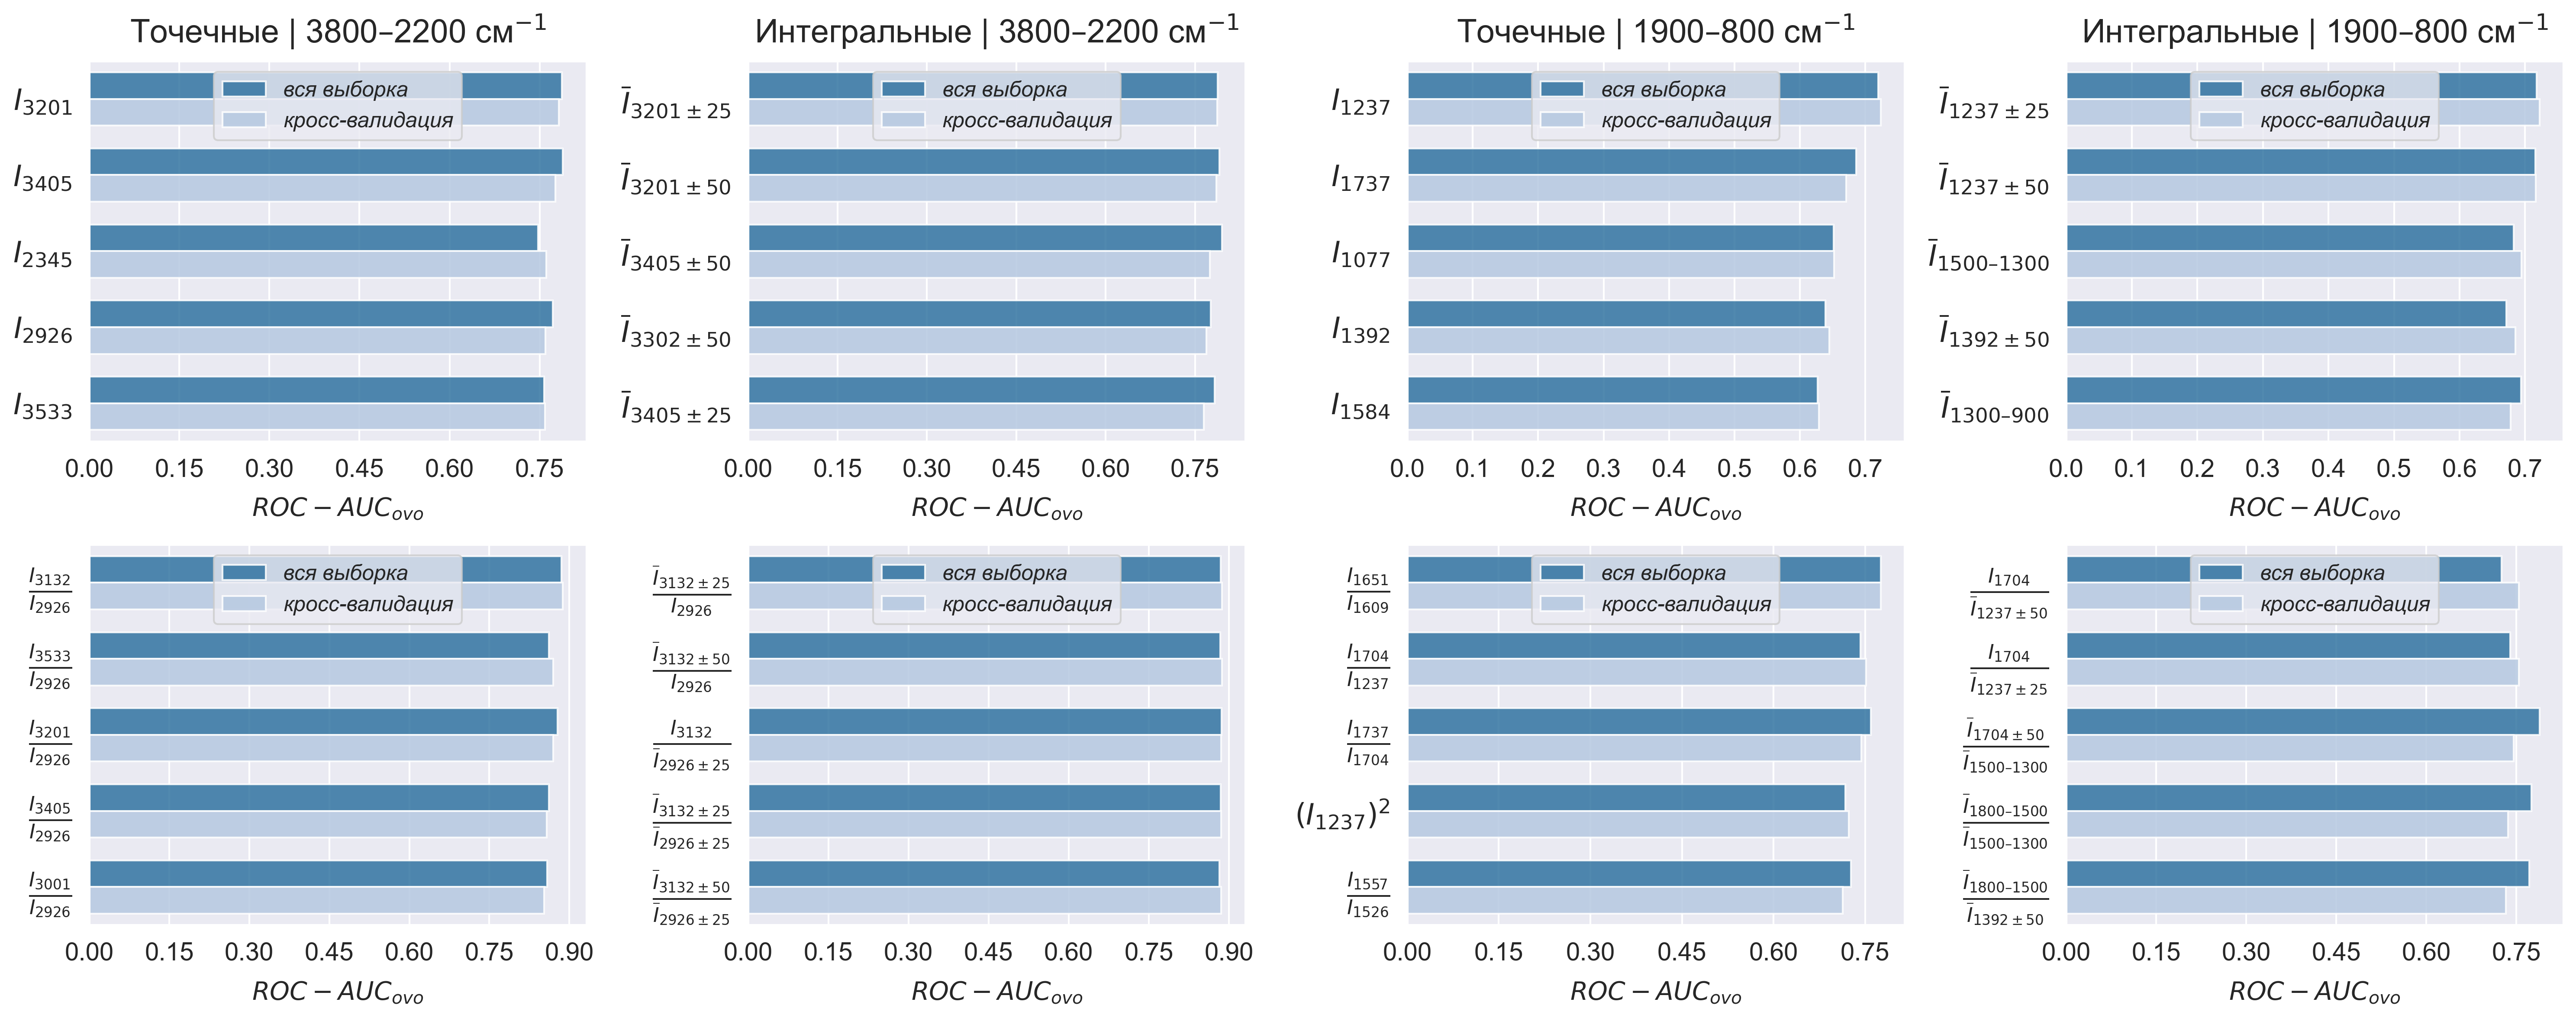

In [22]:
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = of_metrics_expanded_df[of_metrics_expanded_df['Feature_Type'] == feature_type]
    
    result_df = (
        subset
        .sort_values(
            by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'],
            ascending=[False, False]
        )
        .head(PLOT_STYLE['TOP_N'])
        .copy()
    )

    result_df = result_df[['Feature', '$ROC-AUC_{ovr}$', '$ROC-AUC_{ovr}^{CV}$']]
    
    result_df = result_df.melt(id_vars='Feature', var_name='Type', value_name='ROC-AUC')
    result_df['Type'] = result_df['Type'].map({
        '$ROC-AUC_{ovr}$': 'вся выборка',
        '$ROC-AUC_{ovr}^{CV}$': 'кросс-валидация'
    })

    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    
    sns.barplot(
        data=result_df,
        x='ROC-AUC',
        y='Feature',
        hue='Type',
        ax=ax,
        palette=['#1f77b4', '#aec7e8'],
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    if i < 4:
        label = 'Точечные' if 'peaks' in feature_type else 'Интегральные'
        a, b = [s for s in feature_type.split('_') if s.isdigit()][-2:]
        title = f'{label} | {a}–{b} см$^{{-1}}$'
        
        ax.set_title(
            title,
            fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
            fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
            pad=10
        )

    ax.set_xlabel('$ROC-AUC_{ovr}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    legend = ax.legend(loc='upper center', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)
    for text in legend.get_texts():
        text.set_fontstyle('italic')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig(f'{path_to_save}/roc_auc_barplots.png', dpi=600)

plt.show()

### *Hard-check* factor selection

In [23]:
of_features_to_save = (
    of_metrics_df
    .loc[
        (of_metrics_df['$ROC-AUC_{ovr}$'] >= 0.70)
        & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] >= 0.70)
        & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] - of_metrics_df['$ROC-AUC_{ovr}$'] >= -0.05)
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(of_metrics_df["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(of_metrics_df["Feature"].unique()) * 100, 2)}%',
    sep='\n'
)

Число фичей
(*) до отбора: 2551
(*) после отбора: 495
Доля фичей, прошедших однофакторный отбор: 19.4%


## *Multi-factor* analysis

### Functions for processing & config-parameters

In [24]:
PLOT_STYLE = {
    'TITLE': '',
    'TITLE_FONT_SIZE': 12,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 10,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'METRIC_VALUE_FONT_SIZE': 8,
    'Y_NBINS': 10
}

#### Forward selection

In [25]:
def forward_selection_parallel(
    features_df,
    target,
    candidate_features,
    scoring='roc_auc_ovr',
    min_uplift=None,
    max_features=None,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1,
    use_tqdm=True
):
    selected, best_score, history = [], -np.inf, []
    remain = candidate_features.copy()

    def compute_score_for_feature(feat, current_selected):
        feats = current_selected + [feat]
        X = features_df[feats].values
        y = target.values

        estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                multi_class='ovr', penalty='l2', solver='lbfgs', max_iter=10000, random_state=42
            ))
        ])

        if use_cv:
            scores = []
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            for train_idx, test_idx in skf.split(X, y):
                estimator.fit(X[train_idx], y[train_idx])
                y_pred = estimator.predict_proba(X[test_idx])
                try:
                    match scoring:
                        case 'roc_auc_ovr': score = roc_auc_score(y[test_idx], y_pred, multi_class='ovr')
                        case 'roc_auc_ovr': score = roc_auc_score(y[test_idx], y_pred, multi_class='ovr')
                        case 'pr_auc': score = average_precision_score(y[test_idx], y_pred, average='macro')
                        case _: raise ValueError(f'Unsupported metric: {scoring}')
                    scores.append(score)
                except:
                    continue
            return (feat, np.nanmean(scores))
        else:
            estimator.fit(X, y)
            y_pred = estimator.predict_proba(X)
            match scoring:
                case 'roc_auc_ovr': score = roc_auc_score(y, y_pred, multi_class='ovr')
                case 'roc_auc_ovr': score = roc_auc_score(y, y_pred, multi_class='ovr')
                case 'pr_auc': score = average_precision_score(y, y_pred, average='macro')
                case _: raise ValueError(f'Unsupported metric: {scoring}')
            return (feat, score)

    while remain:
        tqdm_iter = tqdm(remain, desc=f'Step {len(selected)+1}') if use_tqdm else remain

        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_score_for_feature)(feat, selected) for feat in tqdm_iter
        )

        results = [r for r in results if r[1] is not None]
        if not results:
            break

        feat_best, score_best = max(results, key=lambda x: x[1])
        uplift = score_best - best_score

        if min_uplift is not None and uplift < min_uplift:
            break

        selected.append(feat_best)
        remain.remove(feat_best)
        best_score = score_best
        history.append({'feature': feat_best, 'score': score_best, 'uplift': uplift})

        if max_features is not None and len(selected) >= max_features:
            break

    return selected, history

#### Labels correction

In [ ]:
def simplify_frac(label):
    return re.sub(r'\\frac\{(.+?)\}\{(.+?)\}', r'\1 / \2', label)

#### *Metric-uplift* bar plot

In [26]:
def plot_cumulative_score_bar(selection_log, ax=None):
    df_log = pd.DataFrame(selection_log)
    df_log['Step'] = range(1, len(df_log) + 1)
    df_log['Cumulative Score'] = df_log['score']
    df_log['Base'] = df_log['Cumulative Score'].shift(fill_value=0)
    df_log['Gain'] = df_log['Cumulative Score'] - df_log['Base']

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(df_log) * 1.5, 5), dpi=150)
        created_fig = True

    for i, row in df_log.iterrows():
        ax.bar(
            x=row['feature'],
            height=row['Gain'],
            bottom=row['Base'],
            width=0.4,
            color=sns.color_palette('crest', n_colors=len(df_log))[i]
        )
        ax.text(
            i,
            row['Cumulative Score'] + 0.001,
            f'{row["Cumulative Score"]:.3f}',
            ha='center',
            va='bottom',
            fontsize=PLOT_STYLE['METRIC_VALUE_FONT_SIZE']
        )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'], rotation=0)
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))

    ax.set_xticks(range(len(df_log)))
    ax.set_xticklabels(df_log['feature'])

    if created_fig:
        plt.tight_layout()
        plt.show()

#### *Metric-uplift* line plot

In [27]:
def plot_cumulative_score_line(selection_log, ax=None):
    df_log = pd.DataFrame(selection_log)
    df_log['Step'] = range(1, len(df_log) + 1)
    df_log['Cumulative Score'] = df_log['score']

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(df_log) * 1.5, 5), dpi=150)
        created_fig = True

    ax.plot(df_log['Step'], df_log['Cumulative Score'], marker='o', linewidth=2)

    for i, row in df_log.iterrows():
        ax.text(
            row['Step'],
            row['Cumulative Score'] + 0.001,
            f'{row["Cumulative Score"]:.3f}',
            ha='center',
            va='bottom',
            fontsize=PLOT_STYLE['METRIC_VALUE_FONT_SIZE']
        )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))

    ax.set_xticks(df_log['Step'])
    ax.set_xticklabels(df_log['feature'], rotation=0)

    if created_fig:
        plt.tight_layout()
        plt.show()

### `3800-2200` cm$^{–1}$

In [28]:
candidate_features_3800_2200 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '3800_2200' in feature_type:
            candidate_features_3800_2200.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200)}')

Число фичей для многофакторного анализа: 450


In [29]:
%%time

selected_feats_3800_2200, selection_log_3800_2200 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2200,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/450 [00:00<?, ?it/s]

Step 2:   0%|          | 0/449 [00:00<?, ?it/s]

Step 3:   0%|          | 0/448 [00:00<?, ?it/s]

Step 4:   0%|          | 0/447 [00:00<?, ?it/s]

Step 5:   0%|          | 0/446 [00:00<?, ?it/s]

CPU times: user 2 s, sys: 257 ms, total: 2.25 s
Wall time: 16.2 s


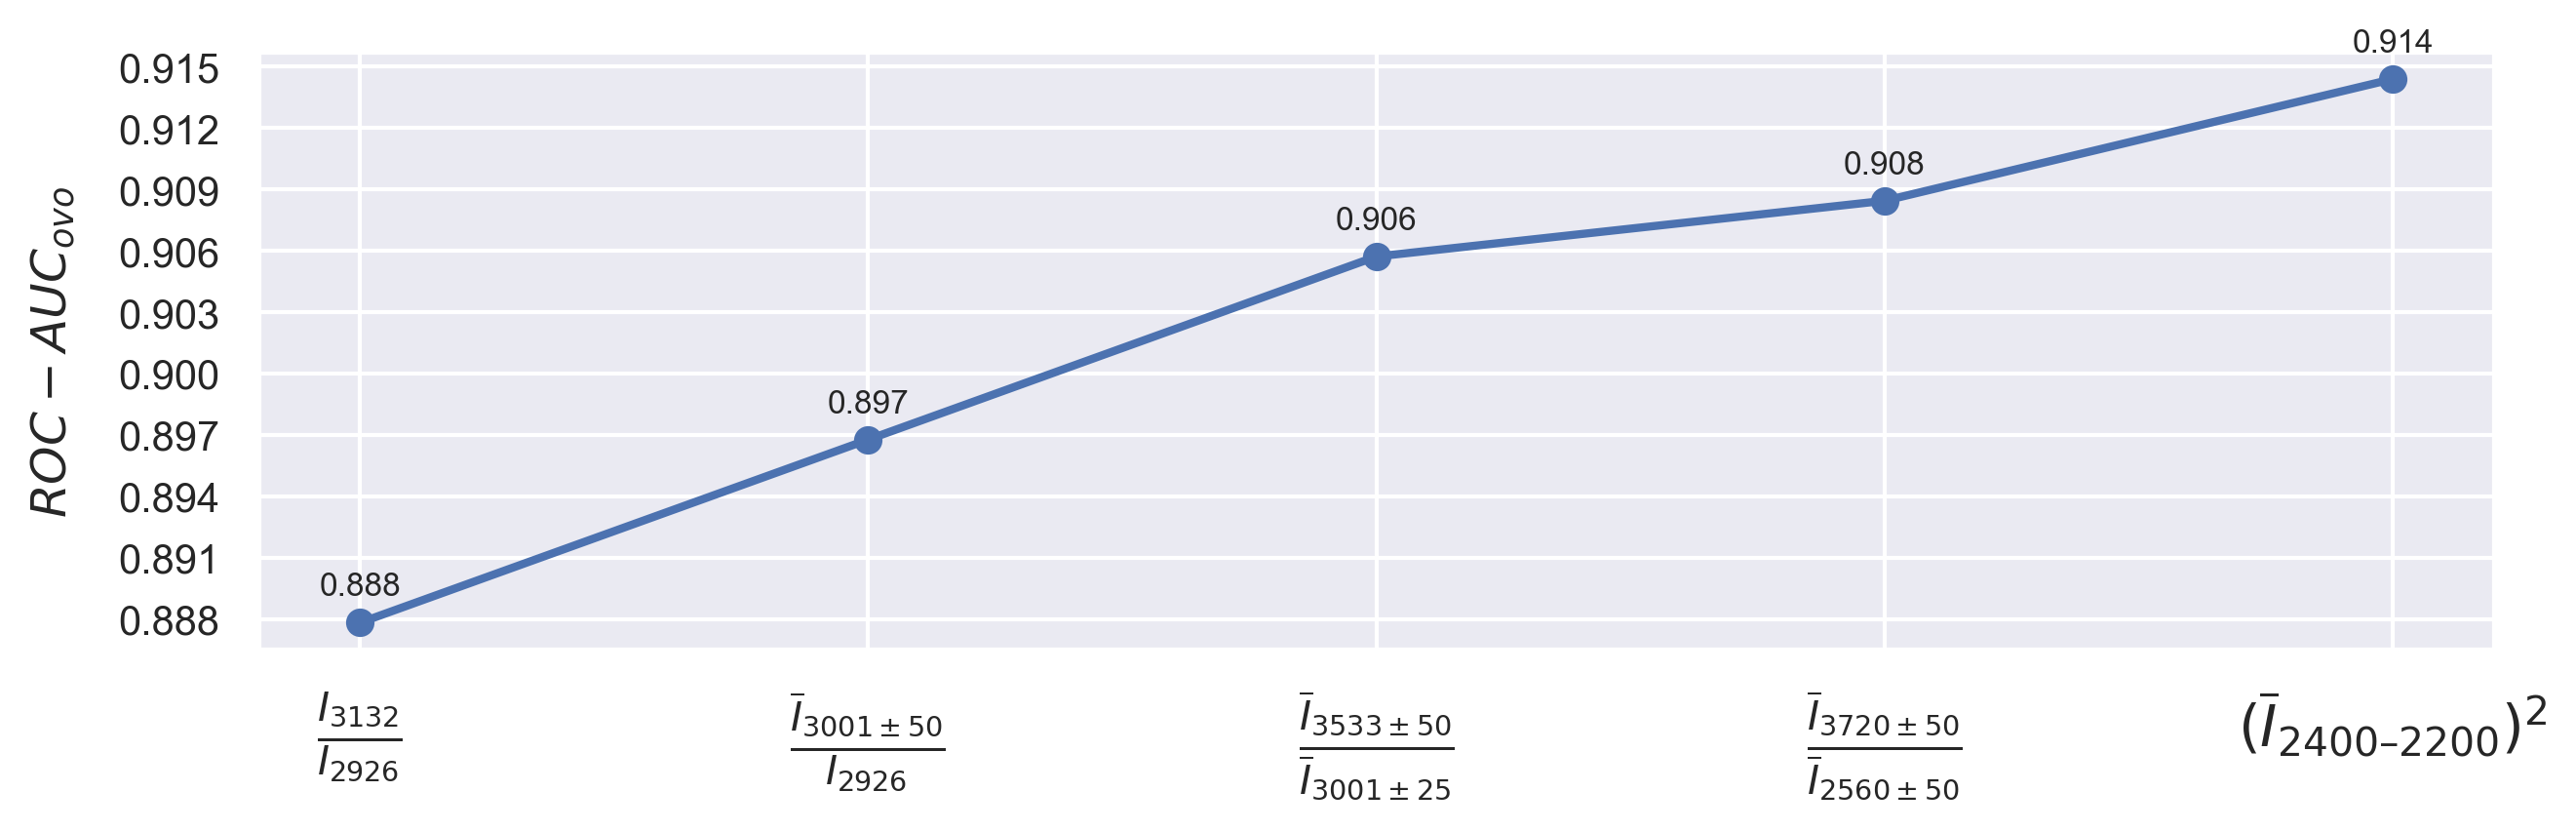

In [30]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_3800_2200,
    ax=ax
)

plt.tight_layout()

# plt.savefig(f'{path_to_save}/fs_3800_2200_uplift_lineplot.png', dpi=600)

plt.show()

### `1900-800` cm$^{–1}$

#### Feature selection process

In [31]:
candidate_features_1900_800 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '1900_800' in feature_type:
            candidate_features_1900_800.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_1900_800)}')

Число фичей для многофакторного анализа: 45


In [32]:
%%time

selected_feats_1900_800, selection_log_1900_800 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/45 [00:00<?, ?it/s]

Step 2:   0%|          | 0/44 [00:00<?, ?it/s]

Step 3:   0%|          | 0/43 [00:00<?, ?it/s]

Step 4:   0%|          | 0/42 [00:00<?, ?it/s]

Step 5:   0%|          | 0/41 [00:00<?, ?it/s]

CPU times: user 433 ms, sys: 62.4 ms, total: 495 ms
Wall time: 2.01 s


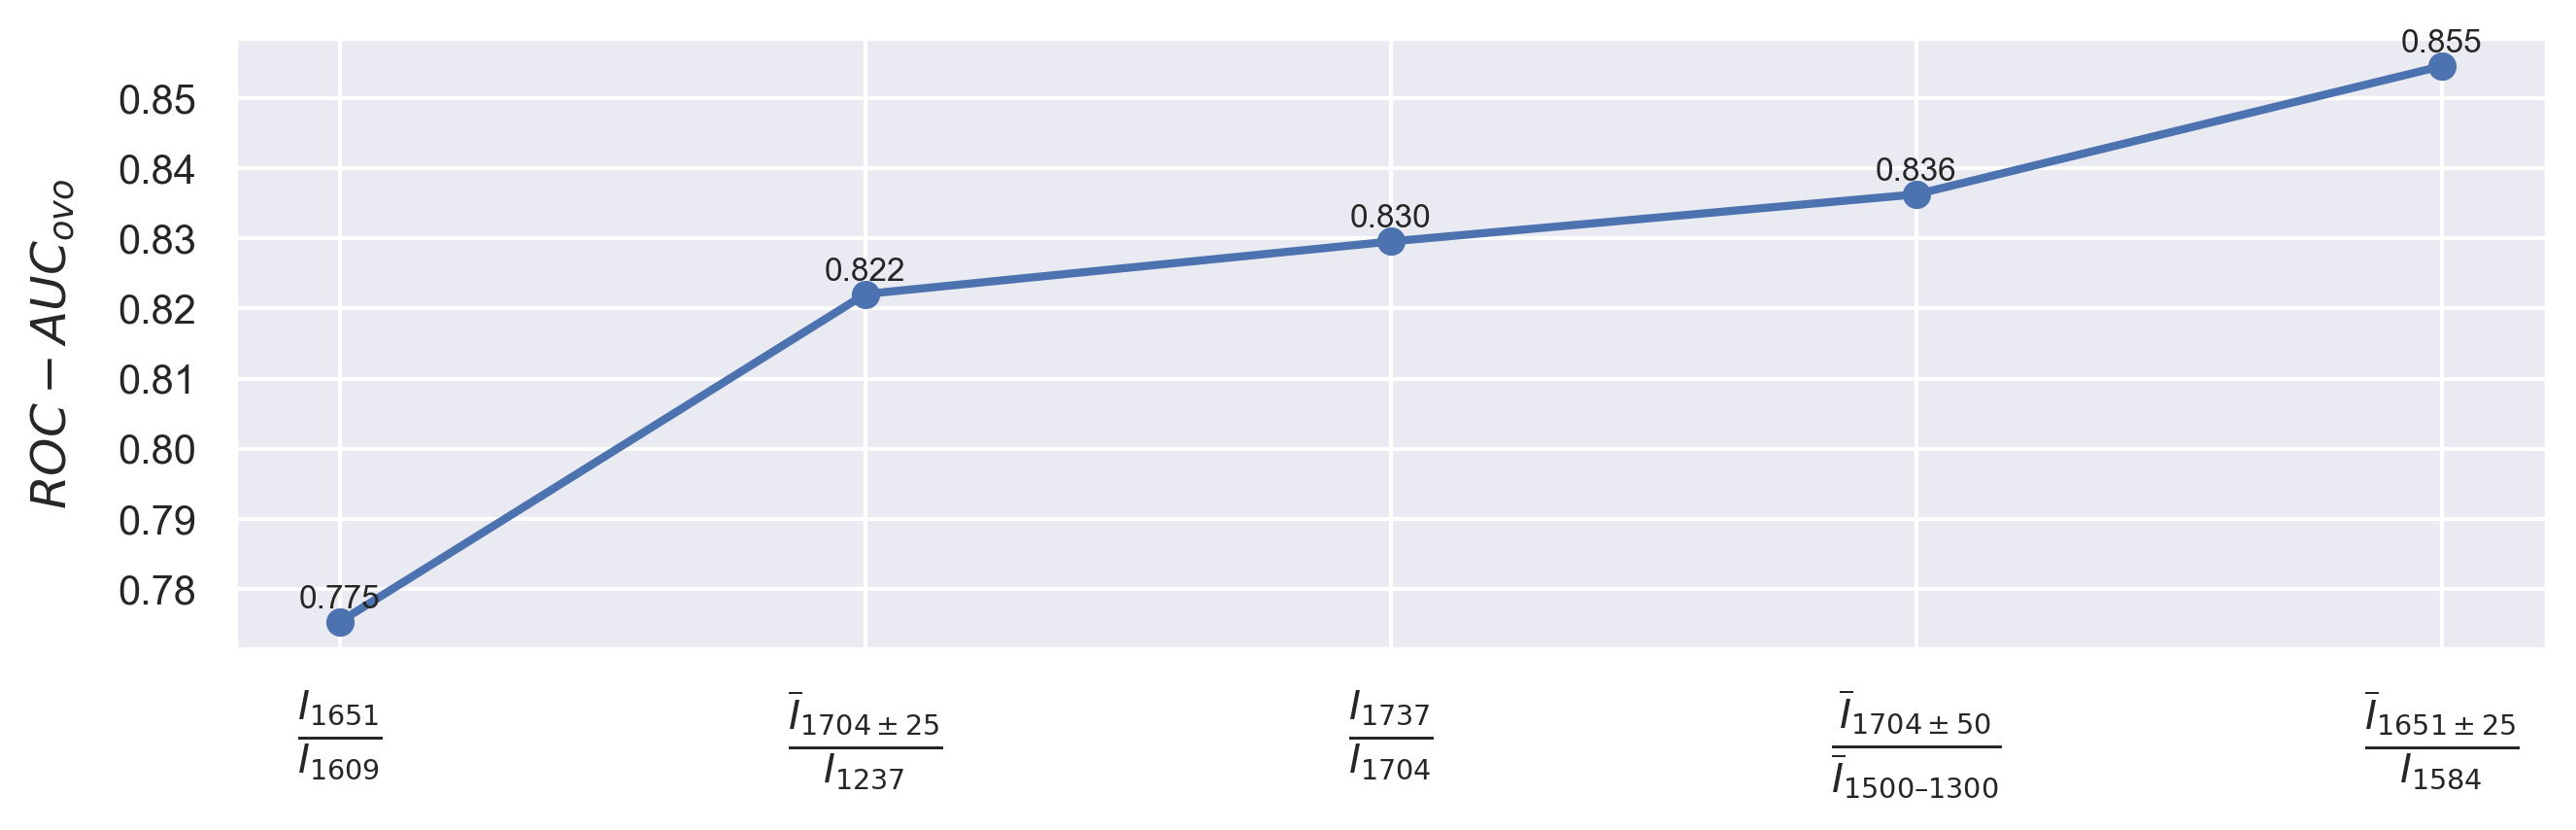

In [33]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_1900_800,
    ax=ax
)

plt.tight_layout()

# plt.savefig(f'{path_to_save}/fs_1900_800_uplift_lineplot.png', dpi=600)

plt.show()

### `3800-2200` x `1900-800` cm$^{–1}$

In [34]:
candidate_features_3800_2200_1900_800 = of_features_to_save.copy()

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200_1900_800)}')

Число фичей для многофакторного анализа: 495


In [35]:
%%time

selected_feats_3800_2200_1900_800, selection_log_3800_2200_1900_800 = forward_selection_parallel(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2200_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.002,
    max_features=5,
    use_cv=True,
    cv_folds=5,
    n_jobs=-1
)

Step 1:   0%|          | 0/495 [00:00<?, ?it/s]

Step 2:   0%|          | 0/494 [00:00<?, ?it/s]

Step 3:   0%|          | 0/493 [00:00<?, ?it/s]

Step 4:   0%|          | 0/492 [00:00<?, ?it/s]

Step 5:   0%|          | 0/491 [00:00<?, ?it/s]

CPU times: user 2.19 s, sys: 274 ms, total: 2.47 s
Wall time: 16.4 s


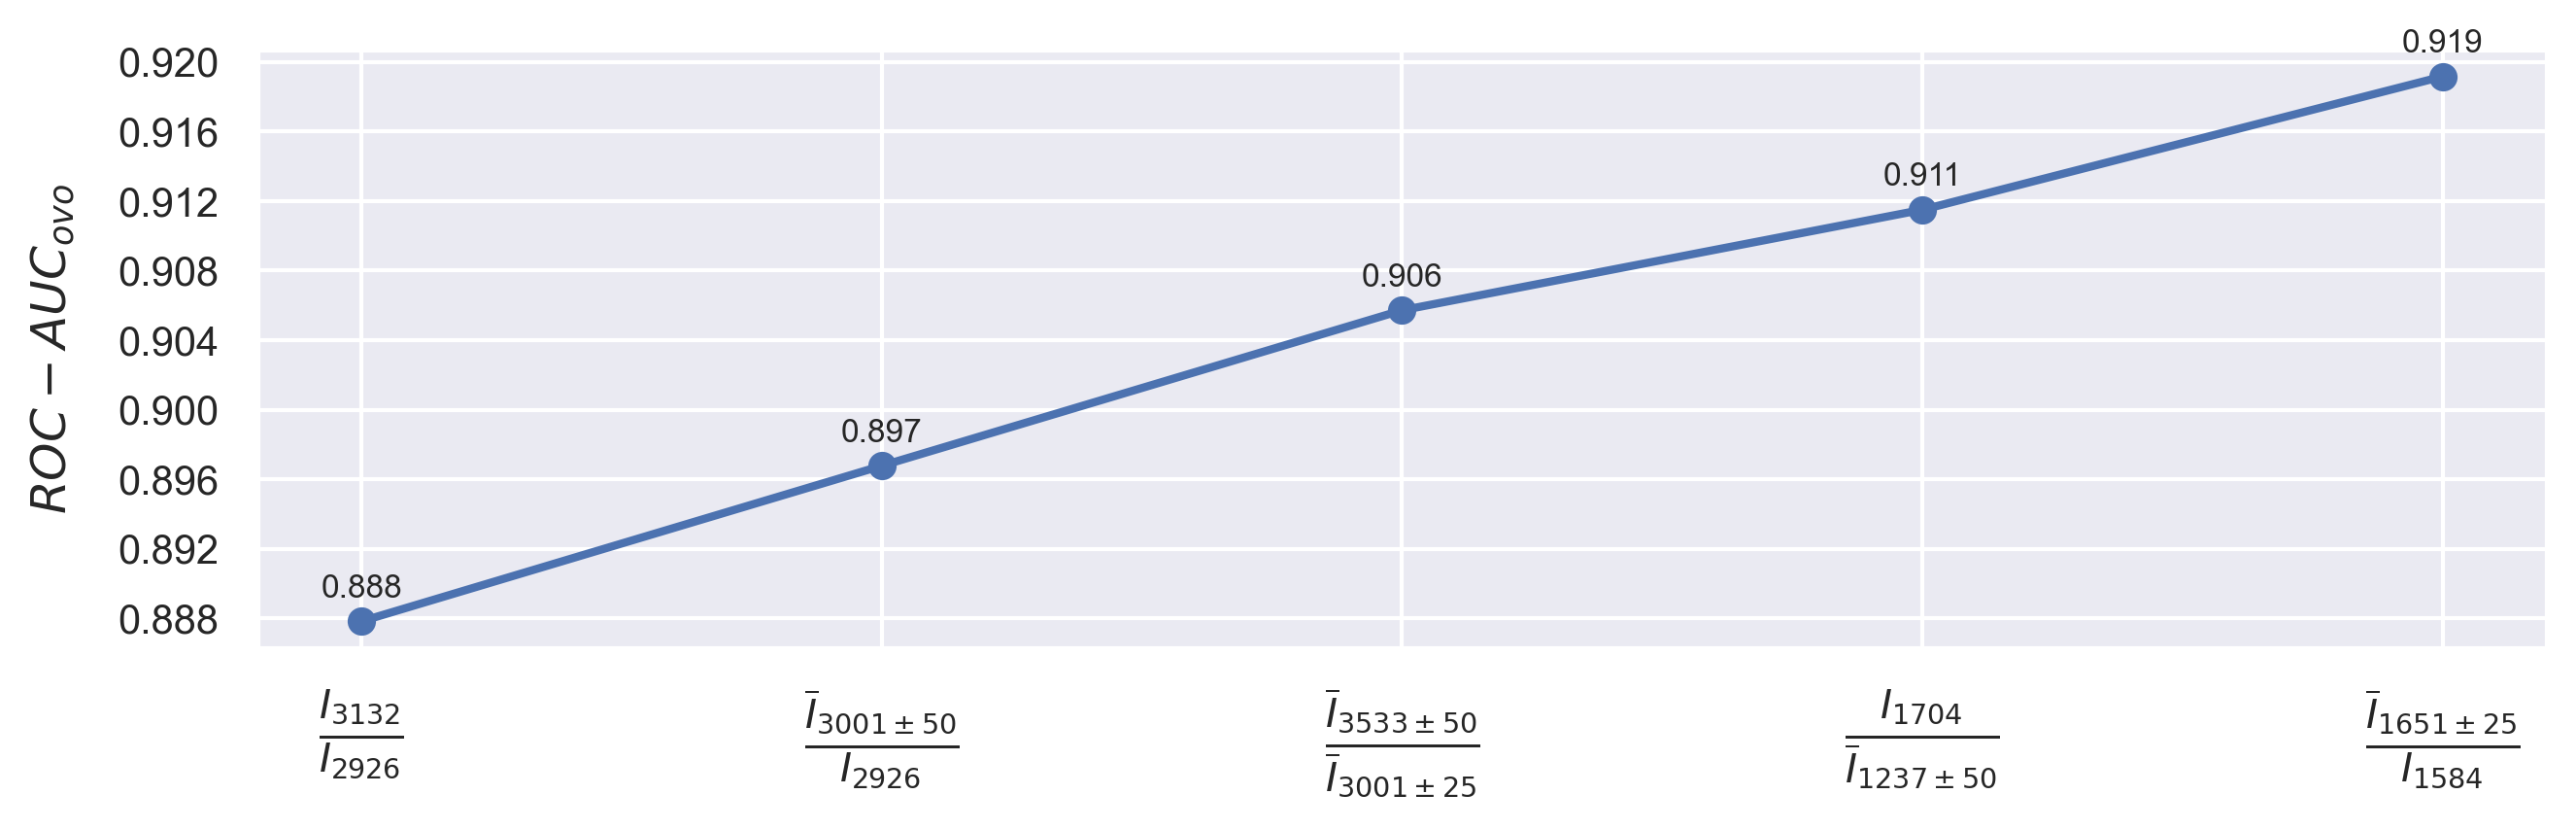

In [36]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line(
    selection_log=selection_log_3800_2200_1900_800,
    ax=ax
)

plt.tight_layout()

# plt.savefig(f'{path_to_save}/fs_3800_2200_1900_800_uplift_lineplot.png', dpi=600)

plt.show()

## Models analysis

### Functions for processing

#### Modeling process (*scaling, `lr` fitting, cross-validation, metrics calculation*)

In [37]:
def logreg_analysis(df, feature_list, target, cv_folds=5, random_state=42):
    X = df[feature_list].copy()
    y = target.copy()

    def roc_auc_ovr_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')

    def pr_auc_macro_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return average_precision_score(y_true, y_pred_proba, average='macro')

    clf_cv = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=random_state))
    ])

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    cv_results = cross_validate(
        clf_cv, X, y,
        cv=skf,
        scoring={
            'roc_auc_ovr': roc_auc_ovr_metric,
            'pr_auc_macro': pr_auc_macro_metric
        },
        return_train_score=False
    )

    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled.iloc[:, :] = scaler.fit_transform(X_scaled)

    clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=random_state)
    clf.fit(X_scaled, y)

    y_proba = clf.predict_proba(X_scaled)
    roc_auc_full = roc_auc_score(y, y_proba, multi_class='ovr', average='macro')
    pr_auc_full = average_precision_score(y, y_proba, average='macro')

    coef_df = pd.DataFrame(clf.coef_, columns=feature_list, index=[f'Class {c}' for c in clf.classes_])
    coef_df['Intercept'] = clf.intercept_

    scaler_df = pd.DataFrame({
        'Feature': feature_list,
        'Mean': scaler.mean_,
        'Std': scaler.scale_
    })

    def ci95(series):
        mean = np.mean(series)
        std = np.std(series, ddof=1)
        n = len(series)
        t_score = t.ppf(0.975, df=n-1)
        margin = t_score * std / np.sqrt(n)
        return mean, margin

    roc_auc_mean, roc_auc_ci = ci95(cv_results['test_roc_auc_ovr'])
    pr_auc_mean, pr_auc_ci = ci95(cv_results['test_pr_auc_macro'])

    metrics_df = pd.DataFrame({
        '$ROC-AUC_{ovr}$': {
            'Mean': roc_auc_mean,
            '$CI_{95, cv}$': roc_auc_ci,
            '$all$ $sample$': roc_auc_full
        },
        '$PR-AUC_{macro}$': {
            'Mean': pr_auc_mean,
            '$CI_{95, cv}$': pr_auc_ci,
            '$all$ $sample$': pr_auc_full
        }
    })

    return clf, X_scaled, scaler_df, coef_df, metrics_df

#### *SHAP*-values visualization (*beeswarm*)

In [109]:
def plot_shap_summary_logreg(model, X_scaled, features_lst, class_index=0, max_display=20, show_colorbar=True, ax=None):
    explainer = shap.LinearExplainer(model, X_scaled, feature_perturbation='interventional')
    shap_values = explainer(X_scaled)
    shap_values_class = shap_values[..., class_index] if model.coef_.shape[0] > 1 else shap_values
    shap_values_class.feature_names = list(features_lst)

    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    shap.plots.beeswarm(
        shap_values_class,
        max_display=max_display,
        show=False,
        color_bar=show_colorbar,
        ax=ax,
        s=PLOT_STYLE['DOT_SIZE'],
        plot_size=None
    )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if show_colorbar:
        fig = plt.gcf()
        for other_ax in fig.axes:
            if other_ax is not ax and len(other_ax.get_xticks()) == 0 and len(other_ax.get_yticks()) > 0:
                other_ax.set_ylabel(PLOT_STYLE['LEGEND_TITLE'], fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])
                other_ax.tick_params(labelsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

                if 'COLORBAR_TICKS' in PLOT_STYLE:
                    other_ax.set_yticklabels(PLOT_STYLE['COLORBAR_TICKS'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

#### Feature importance (feature weight) barplot

In [ ]:
def plot_feature_importance_logreg(model, features_lst, max_display=20, ax=None):
    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    coefs = np.abs(model.coef_)
    importance = coefs.mean(axis=0)

    rel_importance = 100 * importance / importance.sum()
    rel_series = pd.Series(rel_importance, index=features_lst).sort_values(ascending=False).head(max_display)

    palette = sns.color_palette(PLOT_STYLE['PALETTE'], n_colors=len(rel_series))
    colors = list(palette)[::-1]  # от меньшего к большему по Y

    rel_series[::-1].plot(kind='barh', ax=ax, color=colors)

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if not external_ax:
        plt.tight_layout()
        plt.show()


#### Partial dependence plot (*PDP*)

### `3800-2200` cm$^{-1}$

#### Model fitting

In [110]:
model, X_scaled, scaler_df, coef_df, metrics_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2200,
    target=target
)

print(X_scaled.shape)
X_scaled.head(3)

(75, 5)


,$\frac{I_{3132}}{I_{2926}}$,$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{\overline{I}_{3533 \pm 50}}{\overline{I}_{3001 \pm 25}}$,$\frac{\overline{I}_{3720 \pm 50}}{\overline{I}_{2560 \pm 50}}$,$(\overline{I}_{2400\text{–}2200})^{2}$
division_1_size_bulk,1.619066,1.234090,0.559839,-0.617417,-0.825498
division_1_size_5,1.330291,0.933462,1.693650,-0.807230,-0.905918
division_1_size_3,0.463126,0.108045,1.599152,-0.662063,-0.717907


*Parameters for scaling*

In [111]:
display(scaler_df.T)

,0,1,2,3,4
Feature,$\frac{I_{3132}}{I_{2926}}$,$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{\overline{I}_{3533 \pm 50}}{\overline{I}_{3001 \pm 25}}$,$\frac{\overline{I}_{3720 \pm 50}}{\overline{I}_{2560 \pm 50}}$,$(\overline{I}_{2400\text{–}2200})^{2}$
Mean,0.946547,0.833819,0.89027,0.713394,0.083973
Std,0.468687,0.286093,0.283653,0.599269,0.068002


*Model parameters (weights & intercept)*

In [112]:
display(coef_df)

,$\frac{I_{3132}}{I_{2926}}$,$\frac{\overline{I}_{3001 \pm 50}}{I_{2926}}$,$\frac{\overline{I}_{3533 \pm 50}}{\overline{I}_{3001 \pm 25}}$,$\frac{\overline{I}_{3720 \pm 50}}{\overline{I}_{2560 \pm 50}}$,$(\overline{I}_{2400\text{–}2200})^{2}$,Intercept
Class 0,-0.994918,-0.785261,-0.484276,0.941104,0.182943,0.011874
Class 1,-0.200794,-0.598344,0.543747,-0.206889,0.643157,1.589584
Class 2,1.195711,1.383605,-0.059472,-0.734215,-0.826100,-1.601458


*Model metrics*

In [113]:
display(metrics_df)

,$ROC-AUC_{OVO}$,$PR-AUC_{macro}$
Mean,0.914389,0.859741
"$CI_{95, cv}$",0.055111,0.087517
$all$ $sample$,0.932534,0.875567


#### *SHAP-values* diagram

In [140]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 18,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

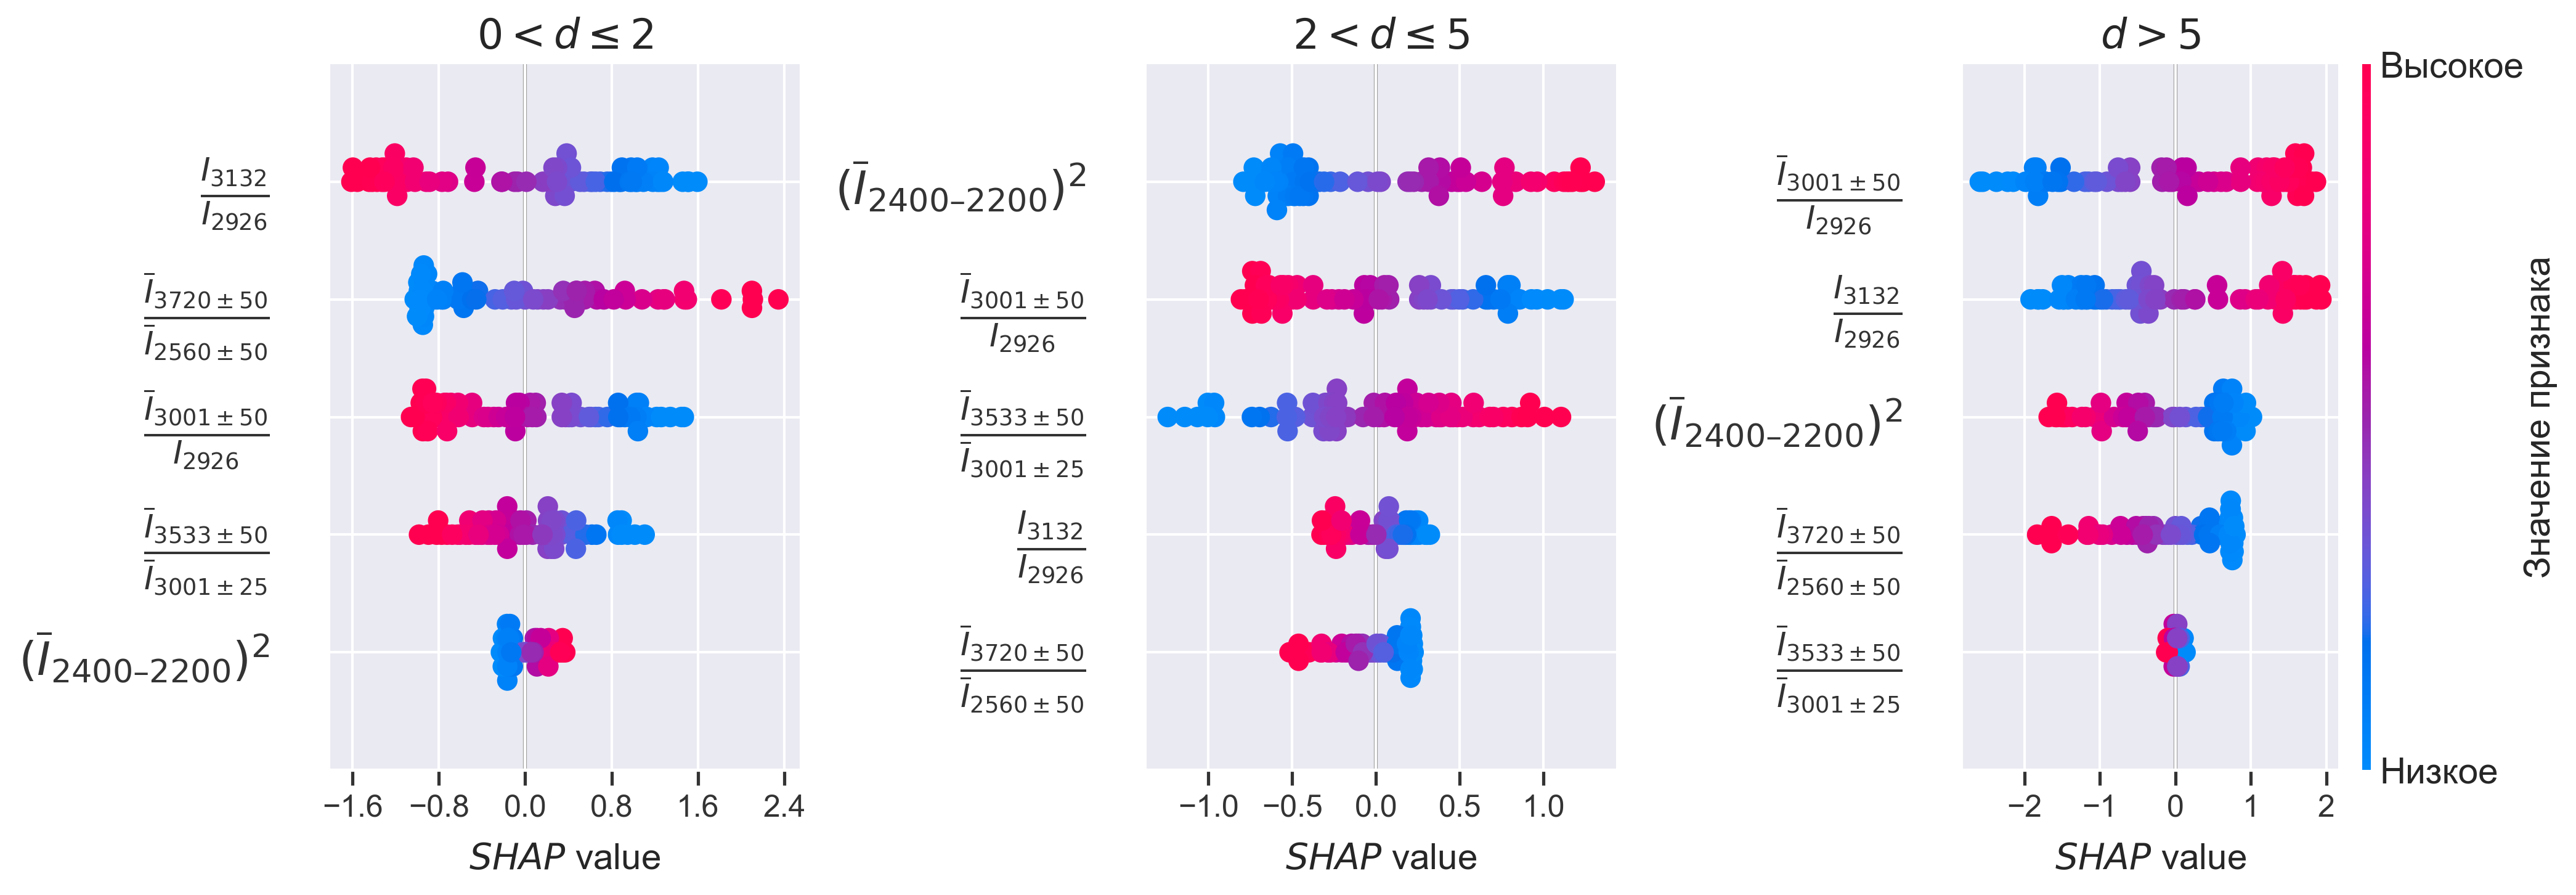

In [142]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_3800_2200.png', dpi=150)

plt.show()

#### *Feature importance* diagram

In [179]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

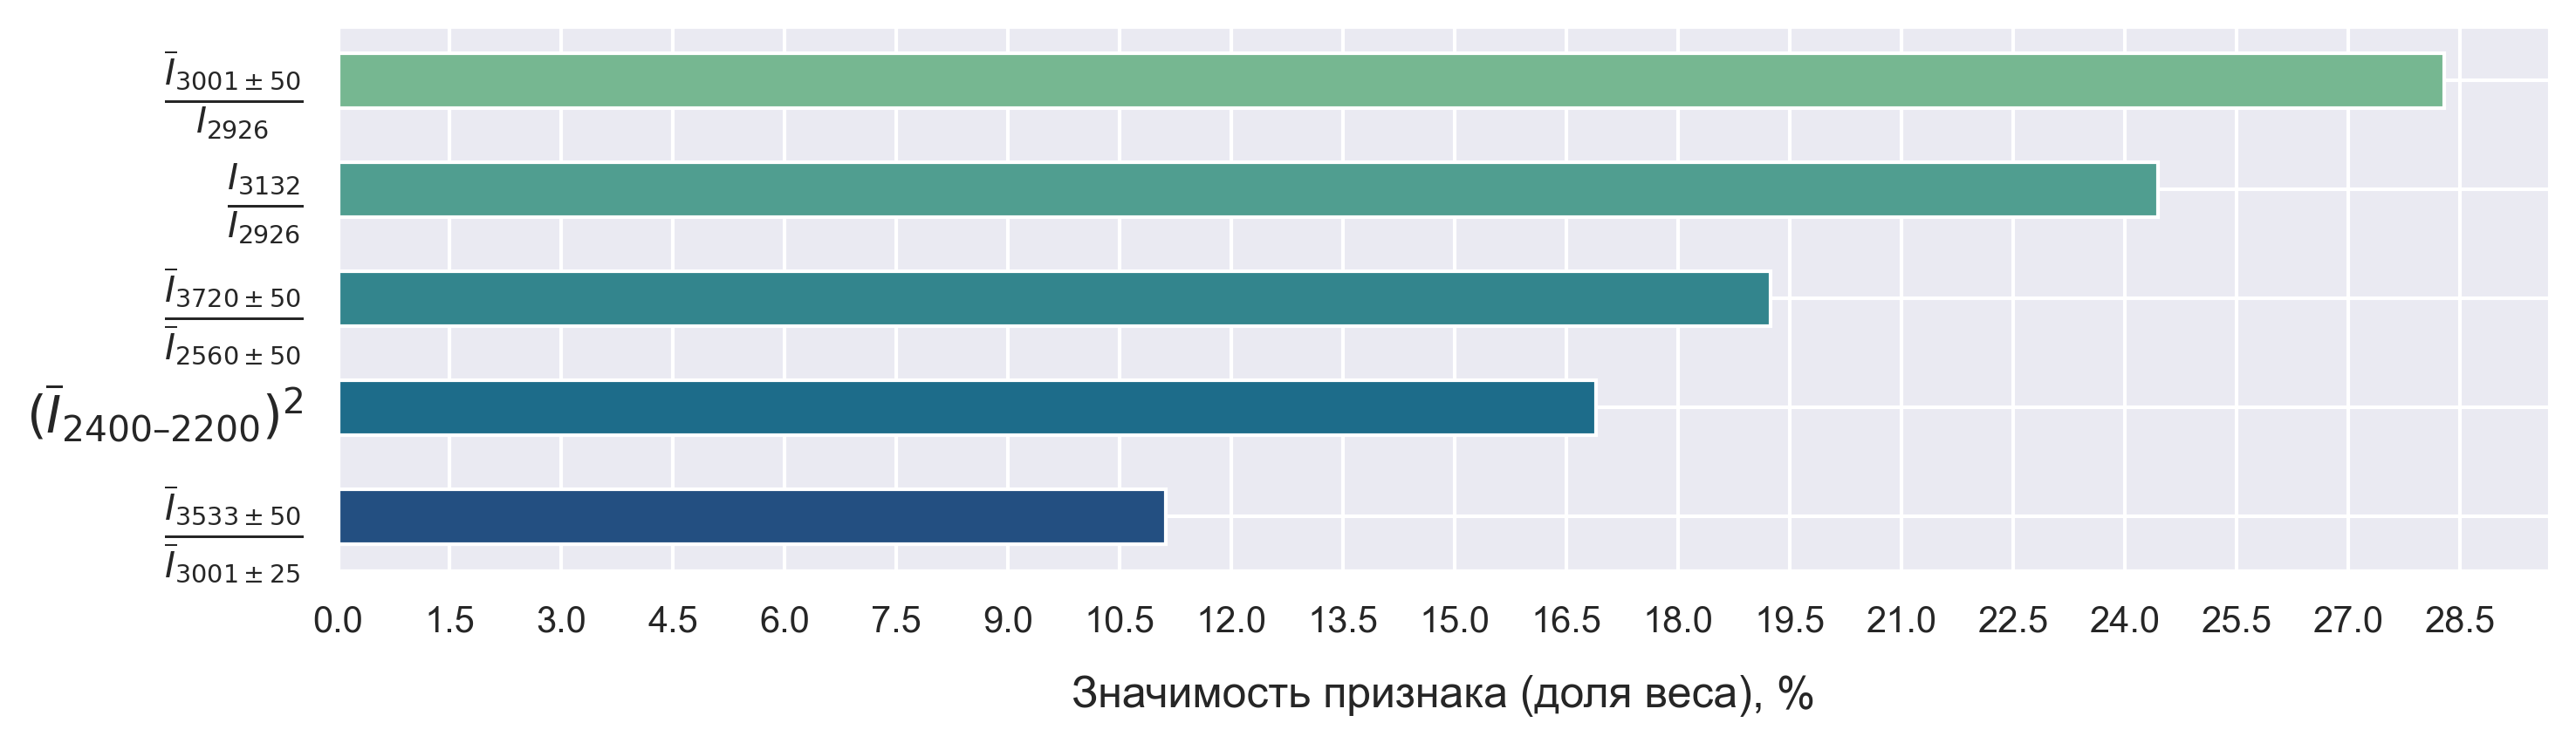

In [180]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

# plt.savefig(f'{path_to_save}/fi_barplot_3800_2200.png', dpi=600)

plt.show()

#### *PDP* diagram

### `1900-800` cm$^{-1}$

In [ ]:
model, scaler_df, coef_df, metrics_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_1900_800,
    target=target
)

display(coef_df)
display(metrics_df)

### `3800-2200 x 1900-800` cm$^{-1}$

In [ ]:
model, scaler_df, coef_df, metrics_df = logreg_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2200_1900_800,
    target=target
)

display(coef_df)
display(metrics_df)